In [1]:
import sys
sys.path.insert(1, './wlcstat/')
import numpy as np
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

In [2]:
from scipy.interpolate import RegularGridInterpolator as RGI

In [3]:
from matplotlib.colors import LogNorm, Normalize

## TODO: 
implement saddle point energy comparison
 - assemble all candidate points in a list
 - for each point calculate free energy (mean field interaction E and binding partition function)
 - determine minimum energy, select that binding state for array

implement interpolation between zero crossing indices (cubic)- ISSUE 2d interpolation



In [4]:
import scipy as scipy
scipy.__version__

'1.10.0'

In [5]:
def eval_f_bind(n_b, n_m, e_m, j_int):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind = 0

    if n_b == 0:
        f_bind = 0
    elif n_b == 1:
        if n_m == 0:
            f_bind = -np.log(2)
        elif n_m == 1:
            f_bind = -np.log(1. + np.exp(-e_m))
        elif n_m == 2:
            f_bind = e_m - np.log(2)
    elif n_b == 2:
        if n_m == 0:
            f_bind = j_int
        elif n_m == 1:
            f_bind = e_m + j_int
        elif n_m == 2:
            f_bind = 2 * e_m + j_int
    
    return f_bind

def find_zero_crossings(matrix):
    zero_crossings = np.where(np.diff(np.signbit(matrix)))
    zero_crossings_vert = np.where(np.diff(np.signbit(matrix), axis=0))
    crossings = np.array(list(zip(zero_crossings[0], zero_crossings[1]))+ list(zip(zero_crossings_vert[0], zero_crossings_vert[1])))
    return crossings

def eval_f_bind_vec(n_b, n_m_arr, e_m, j_int):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        array of Number of reader proteins bound to the nucleosome
    n_m_arr : arr of integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind_arr = np.zeros(len(n_m_arr))
    for i,n_m in enumerate(n_m_arr):
        f_bind = 0
        if n_b == 0:
            f_bind = 0
        elif n_b == 1:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(1. + np.exp(-e_m))
            elif n_m == 2:
                f_bind = e_m - np.log(2)
        elif n_b == 2:
            if n_m == 0:
                f_bind = j_int
            elif n_m == 1:
                f_bind = e_m + j_int
            elif n_m == 2:
                f_bind = 2 * e_m + j_int
        f_bind_arr[i] = f_bind
    return f_bind_arr

# need to produce rank 2 tensor that, given two protein types, 
# find avg of product of s for index ij
def eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, gam1_ind, gam2_ind):
    '''
    poly marks (array of arrays) contains an array of marks per nucleosome for each protein type
    gam1_ind (int) is the index of first protein
    gam2_ind (int) is the index of second protein
    '''
    
    n_bind = len(mu)
    # evaluate eqn 85 for each index ij
 
    phi_bind = phi_c * np.array(f_bars)

    erg_int = np.matmul(phi_bind, v_int) #sum over gamma 2 of int and phi and f

    coef1 = -erg_int[gam1_ind] + mu[gam1_ind] 
    coef2 = -erg_int[gam2_ind] + mu[gam2_ind]
    
#     coef1 = -erg_int[gam1_ind] + mu[gam2_ind] 
#     coef2 = -erg_int[gam2_ind] + mu[gam1_ind]
    
    #make vector form of f_bind
    f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[gam1_ind], e_m[gam1_ind], v_int[gam1_ind,gam1_ind])
    f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[gam1_ind], e_m[gam1_ind], v_int[gam1_ind,gam1_ind])
    f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[gam2_ind], e_m[gam2_ind], v_int[gam2_ind,gam2_ind])
    f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[gam2_ind], e_m[gam2_ind], v_int[gam2_ind,gam2_ind])
    
    #combine coef and f_bind to create 4 dif energies needed
#     - each should be rank 2 tensors
    
    exp_g1_s1 = np.exp(coef1 - f_bind_g1_s1)  #energy at each nucleosome if one gamma 1 protein bound
    exp_g1_s2 = np.exp(2*coef1 - f_bind_g1_s2)
    exp_g2_s1 = np.exp(coef2 - f_bind_g2_s1)
    exp_g2_s2 = np.exp(2*coef2 - f_bind_g2_s2)
    
    exp_11 = np.outer(exp_g1_s1, exp_g2_s1) #getting combined probability at each nucleosome pair
    exp_12 = np.outer(exp_g1_s1, exp_g2_s2)
    exp_21 = np.outer(exp_g1_s2, exp_g2_s1)
    exp_22 = np.outer(exp_g1_s2, exp_g2_s2)
    
    #  (0,0)                (1,0)                                      (0,1)
    q = 1 + np.outer(exp_g1_s1, np.ones(len(exp_g1_s1))) + np.outer(exp_g2_s1, np.ones(len(exp_g1_s1))).T\
    + np.outer(exp_g1_s2,np.ones(len(exp_g1_s1))) + np.outer(exp_g2_s2, np.ones(len(exp_g1_s1))).T\
    + (exp_11 + exp_12 + exp_21 + exp_22) 
    #calculate average matrix (eq 85)
    sisj_bind = (exp_11 + 2*exp_12 + 2*exp_21 + 4*exp_22) / q
    return sisj_bind 

In [6]:
# output MATHCES mark-vecotirzed version!
def slow_eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, gam1_ind, gam2_ind):
    marks_1 = poly_marks[gam1_ind]
    marks_2 = poly_marks[gam2_ind]
    sisj_bind = np.zeros((len(marks_1), len(marks_2)))
    
    phi_bind_arr = phi_c * np.array(f_bars)
#             erg_int = np.matmul(v_int, phi_bind_arr)
    erg_int = np.matmul(phi_bind_arr, v_int)
    
    coef1 = -erg_int[gam1_ind] + mu[gam1_ind] 
    coef2 = -erg_int[gam2_ind] + mu[gam2_ind]
        
    for i, mark1 in enumerate(marks_1):
        for j, mark2 in enumerate(marks_2):
            f_bind_g1_s1 = eval_f_bind(1, mark1, e_m[gam1_ind], v_int[gam1_ind, gam1_ind])
            f_bind_g1_s2 = eval_f_bind(2, mark1, e_m[gam1_ind], v_int[gam1_ind, gam1_ind])
            f_bind_g2_s1 = eval_f_bind(1, mark2, e_m[gam2_ind], v_int[gam2_ind, gam2_ind])
            f_bind_g2_s2 = eval_f_bind(2, mark2, e_m[gam2_ind], v_int[gam2_ind, gam2_ind])
            
            exp_g1_s1 = np.exp(coef1 - f_bind_g1_s1)  #energy at each nucleosome if one gamma 1 protein bound
            exp_g1_s2 = np.exp(2*coef1 - f_bind_g1_s2)
            exp_g2_s1 = np.exp(coef2 - f_bind_g2_s1)
            exp_g2_s2 = np.exp(2*coef2 - f_bind_g2_s2)

            exp_11 = exp_g1_s1 * exp_g2_s1 #getting combined probability at each nucleosome pair
            exp_12 = exp_g1_s1 * exp_g2_s2
            exp_21 = exp_g1_s2 * exp_g2_s1
            exp_22 = exp_g1_s2 * exp_g2_s2           

            q = 1 + exp_g1_s1 + exp_g2_s1 + exp_g1_s2 + exp_g2_s2 + (exp_11 + exp_12 + exp_21 + exp_22) 
            #calculate average matrix (eq 85)
            sisj_bind[i,j] = (exp_11 + 2*exp_12 + 2*exp_21 + 4*exp_22) / q           
            
    return sisj_bind

In [7]:
# def find_zero_crossings(matrix):
#     zero_crossings = np.where(np.diff(np.signbit(matrix)))
#     zero_crossings_vert = np.where(np.diff(np.signbit(matrix), axis=0))
#     crossings = np.array(list(zip(zero_crossings[0], zero_crossings[1]))+ list(zip(zero_crossings_vert[0], zero_crossings_vert[1])))
#     return crossings

## Langmuir isotherm analysis single , double protein

In [8]:
# np.ones((len(marks_1), len(marks_2)))

In [9]:
# marks_1 = np.loadtxt(r"C:\Users\tmhab\Downloads\H3K9me3_ENCFF651ZTT_Chr_22_trimmed.txt").astype(np.uint8)
# marks_2 = np.loadtxt(r"C:\Users\tmhab\Downloads\H3K27me3_ENCFF470ECE_Chr_22_trimmed.txt").astype(np.uint8)

# n = int(1e5 + 15050)
# marks_1 = marks_1[n:n+(len(marks_1)//10000)]
# marks_2 = marks_2[n:n+(len(marks_2)//10000)]

In [10]:
# f_om = np.array([(np.array(marks_1)==0).sum(),(np.array(marks_1)==1).sum(),(np.array(marks_1)==2).sum(), \
#                     (np.array(marks_2)==0).sum(),(np.array(marks_2)==1).sum(),(np.array(marks_2)==2).sum()])/len(marks_1)

In [11]:
# marks_1

In [12]:
# marks_2

In [39]:
n_bind = 2 #types of proteins/marks

e_m = np.array([-1.5, -1.5]) #binding energy
# e_m = np.array([-1., -1.5]) #binding energy
# e_m = np.array([0,-1.5]) #binding energy

# v_int = np.array([[-3.92, 3.0],[3.0, -3.92]])

v_int = np.array([[-3., 3.92],[3.92, -3.]])

# v_int = np.array([[-3.92,0],[0,-3.92]]) # protein-protein interaction param
# v_int = np.array([[0,3.92],[3.92,0]]) # protein-protein interaction param
# v_int = np.array([[-1,0],[0,-1]]) # protein-protein interaction param
# v_int = np.array([[0,0],[0,0]]) # protein-protein interaction param
# v_int = np.array([[1e-5,1e-5],[1e-5,1e-5]]) # protein-protein interaction param
# v_int = np.array([[-2,0.5],[0.5,-1]]) # protein-protein interaction param
# v_int = np.array([[0,1],[1,0]]) # protein-protein interaction param

phi_c = 0.6# avg amount of chromosome 
# phi_c = 1.# avg amount of chromosome 

marks_1 = [0,2,1,0,2,1] # marks for protein 1
marks_2 = [1,1,1,0,2,2] # marks for protein 2


# marks_1 = [0,0,0,0,2,1] # marks for protein 1
# marks_2 = [0,0,0,0,2,2] # marks for protein 2

# marks_1 = [0,0,0,2,2,2] # marks for protein 1
# marks_2 = [2,2,2,0,0,0] # marks for protein 2

# marks_1 = [2,2,2,0,0,0] # marks for protein 1
# marks_2 = [2,2,2,0,0,0] # marks for protein 2

# marks_1 = [0,0,0,0] # marks for protein 1
# marks_2 = [0,0,0,0] # marks for protein 2

# marks_1 = [0,1,2] # marks for protein 1
# marks_2 = [0,1,2] # marks for protein 2

# marks_1 = [0,1,1,2,0,0] # marks for protein 1
# marks_2 = [1,0,1,2,2,1] # marks for protein 2


# fraction of nucleosomes with 0,1,2 marks per protein type, calculated form marks1, marks2: 
f_om = np.array([(np.array(marks_1)==0).sum(),(np.array(marks_1)==1).sum(),(np.array(marks_1)==2).sum(), \
                    (np.array(marks_2)==0).sum(),(np.array(marks_2)==1).sum(),(np.array(marks_2)==2).sum()])/len(marks_1)
poly_marks = [marks_1, marks_2]

# l_p = 53 # 53 nm
# bp_p_b = 45 # base pairs per bond
# nm_p_bp = 0.34 # nanometetrs per base pair
# b = l_p * 2 #kuhn length

# N = (len(marks_1)-1) * bp_p_b * nm_p_bp * (1/b)
# N_m = N/(len(marks_1)-1)


b = 1
N_m = 1000
N = N_m * len(marks_1)

In [40]:
def calc_saddle_point_E(f_bars, phi_c, v_int, mu, poly_marks, e_m):
    # For two protein types, calculates the part of saddle point free energy that changes when the 
    # average binding state changes
    # f_gammas: list of the two average binding fractions, one for each protein type
    
    # calc mean-field protein-protein interaction
#     print("f_bars:", f_bars)
    mf_pp_int = 0.5*phi_c**2
    for g1 in range(len(f_bars)):
        for g2 in range(len(f_bars)):
            mf_pp_int += v_int[g1][g2]*f_bars[g1]*f_bars[g2]
#     print(" mean-field protein-protein interaction: ", mf_pp_int)
    # calc binding partition function

    phi_bind_arr = phi_c * np.array(f_bars)
#             erg_int = np.matmul(v_int, phi_bind_arr)
    erg_int = np.matmul(phi_bind_arr, v_int)
    
    coef1 = -erg_int[0] + mu[0] 
    coef2 = -erg_int[1] + mu[1]    
    
    f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[0], e_m[0], v_int[0,0])
    f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[0], e_m[0], v_int[0,0])
    f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[1], e_m[1], v_int[1,1])
    f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[1], e_m[1], v_int[1,1])
    
    gam1_part = np.sum(np.log(1 + np.exp(coef1 - f_bind_g1_s1) + np.exp(2*coef1 - f_bind_g1_s2)))
    gam2_part = np.sum(np.log(1 + np.exp(coef2 - f_bind_g2_s1) + np.exp(2*coef2 - f_bind_g2_s2)))
    
    bind_part = phi_c*(gam1_part + gam2_part)
#     print(-1 * (mf_pp_int + bind_part))
    return -1 * (mf_pp_int + bind_part)

In [41]:
# %%time
# TWO PROTEIN TYPES
#TODO: 
#  - deal with multiple solutions (currently, just choosing minimum soln)

mu_max = 10
mu_min = -10
#denisty map setting
mu1_array = np.arange(mu_min, mu_max, 1)#[-5]
mu2_array = np.arange(mu_min, mu_max, 1)#[-5]
f_gam_arr = np.arange(-0.01,2.02,0.01)

#1d plot settings
# mu1_array = np.arange(-10, 10, 0.01)#[-5]
# mu2_array = np.arange(-10, 10, 0.01)#[-5]
# f_gam_arr = np.arange(-0.005,2.02,0.001)

# mu1_array = [0]#np.arange(-10, 10, 0.5)#[-5]
# mu2_array = [0]#np.arange(-10, 10, 0.5)#[-5]
# f_gam_arr = np.arange(-0.,2.01,0.01)

f_gam_soln_arr = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

s_bind_soln_arr = np.zeros((n_bind*3, len(mu1_array), len(mu2_array)))

f_gam_soln_arr_max = np.zeros((n_bind, len(mu1_array), len(mu2_array)))
f_gam_soln_arr_min = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

multi_soln_mus = np.zeros((len(mu1_array), len(mu2_array)))
for k, mu1 in enumerate(mu1_array):
    for l, mu2 in enumerate(mu2_array):
        mu = [mu1, mu2]
        

        # 1) generate right hand side (RHS) of f_gamma1 and f_gamma2 as 2d matrices ( [f1, f2] )


        phi_bind_arr = np.zeros(len(f_gam_arr))
        phi_bind_arr = phi_c * f_gam_arr

        RHS = np.zeros(len(f_gam_arr))
        RHS_arr = np.zeros((n_bind, len(f_gam_arr),len(f_gam_arr)))

        f1,f2 = np.meshgrid(f_gam_arr,f_gam_arr)
        combined_matrix = np.dstack((f1*phi_c, f2*phi_c))#.tolist()
#         erg_int = np.einsum('kl,ijk->jil', v_int, combined_matrix)  #WORKS this is the mat mul of each fgamma pair
        erg_int = np.einsum('ijk,kl->jil', combined_matrix, v_int)  # this is the mat mul of each fgamma pair

        erg_ints = np.split(erg_int, n_bind, axis=2)
        for i in range(len(erg_ints)):
            erg_ints[i] = np.squeeze(erg_ints[i])

        for mark in range(n_bind): # for each reader protein/ mark type
            for om in range(3): 
                f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
                f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
                q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])

                RHS = RHS_arr[mark] 

                RHS += f_om[om+(mark*3)] * (np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + 
                                             2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])) / q 
                RHS_arr[mark] = RHS

                


        # 2) self-consistently solve for fgamma1 and fgamma2, finding where the difference (fgamma-RHS) crosses zero

        
        
        X, Y = np.meshgrid(f_gam_arr, f_gam_arr)

        crs1 = find_zero_crossings(RHS_arr[0]-Y)
        crs2 = find_zero_crossings(RHS_arr[1]-X)

        
        
        # 3) find the intersection of the sets of fgamma_n solutions, such that both f_gammas are self consistent


        
        aset = set([tuple(x) for x in crs1])
        bset = set([tuple(x) for x in crs2])
        inds = np.array([x for x in aset & bset])+1

        f_gam_solns = np.zeros(len(inds), dtype = "object")#f_gam_arr[inds[0]]
        min_soln = [-1]*n_bind
        min_E_soln = [None]*n_bind
        min_E = None

# #################### 2), 3) interpolation of entire RHS-Y. slower ##########################
#         r0 = RGI((f_gam_arr, f_gam_arr), (RHS[0]-Y).T, method='cubic', bounds_error=False)
#         r1 = RGI((f_gam_arr, f_gam_arr), (RHS[1]-X).T, method='cubic', bounds_error=False)
#         f_gam_arr_new = np.arange(-0.,2.01,0.001)
        
#         Xnew, Ynew = np.meshgrid(f_gam_arr_new, f_gam_arr_new, indexing='ij', sparse=True)
#         RHS0_diff_new = r0((Xnew, Ynew))
#         RHS1_diff_new = r1((Xnew, Ynew))
# #         print("used interp object to gen fine data")
#         crs1_new = find_zero_crossings(RHS0_diff_new)
#         crs2_new = find_zero_crossings(RHS1_diff_new)
# #         print("found zero crossing of new data")

#         aset_new = set([tuple(x) for x in crs1_new])
#         bset_new = set([tuple(x) for x in crs2_new])
#         inds_new = np.array([x for x in aset_new & bset_new])+1

#         f_gam_solns_new = np.zeros(len(inds_new), dtype = "object")#f_gam_arr[inds[0]]
#         min_soln = [-1]*n_bind

#         for i in range(len(inds_new)):            
#             soln = f_gam_arr_new[inds_new[i]]           
# #             f_gam_solns_new[i] = soln
            
#             print("new soln: ", soln)
        
        
#############################################################################################
#         print("mu: ", mu)

#         print("poss solns: ", f_gam_arr[inds])
        for i in range(len(inds)):
#             # TODO implement interpolation for each solution, only in vicinity (essentially redo entire analysis)
#             # for each point, get an array of all neighboring points (x,y) and at those points RHS - Y, RHS - X (z)
#             ind = inds[i]
#             # find all neighboring indices
#             pos_xs = np.array([ind[0], ind[0]+1, ind[0]-1])
#             valid_xs = pos_xs[(pos_xs > -1) | (pos_xs < len(mu1_array))]
            
#             pos_ys = np.array([ind[1], ind[1]+1, ind[1]-1])
#             valid_ys = pos_ys[(pos_ys > -1) | (pos_ys < len(mu1_array))]
            
#             x_near_zr, y_near_zr = np.meshgrid(f_gam_arr[valid_xs], f_gam_arr[valid_ys])

#             # evaluate RHS[0]-Y, RHS[1] -X at those indices
# #            RHS0miny = RHS_arr[0][min(valid_xs):max(valid_xs),min(valid_ys):max(valid_ys)] - y_near_zr
# #            RHS1minx = RHS_arr[1][min(valid_xs):max(valid_xs),min(valid_ys):max(valid_ys)] - x_near_zr

#             RHS0miny = (RHS_arr[0]-Y)[min(valid_xs):max(valid_xs),min(valid_ys):max(valid_ys)]
#             RHS1minx = (RHS_arr[1]-X)[min(valid_xs):max(valid_xs),min(valid_ys):max(valid_ys)]

#             # 2d interpolate 
#             r0 = RGI((f_gam_arr[valid_xs], f_gam_arr[valid_ys]), RHS0miny.T, method='cubic', bounds_error=False)
#             r1 = RGI((f_gam_arr[valid_xs], f_gam_arr[valid_ys]), RHS1minx.T, method='cubic', bounds_error=False)

#             xnew = np.arange(f_gam_arr[min(valid_xs)], f_gam_arr[max(valid_xs)], 0.0001)
#             ynew = np.arange(f_gam_arr[min(valid_ys)], f_gam_arr[max(valid_ys)], 0.0001)
#             Xnew, Ynew = np.meshgrid(xnew, ynew, indexing='ij', sparse=True)

#             RHS0_diff_new = r0((Xnew, Ynew))
#             RHS1_diff_new = r1((Xnew, Ynew))

#             crs1_new = find_zero_crossings(RHS0_diff_new)
#             crs2_new = find_zero_crossings(RHS1_diff_new)

#             aset_new = set([tuple(x) for x in crs1_new])
#             bset_new = set([tuple(x) for x in crs2_new])
#             inds_new = np.array([x for x in aset_new & bset_new])+1

    #         f_gam_solns_new = np.zeros(len(inds_new), dtype = "object")#f_gam_arr[inds[0]]
    #         min_soln = [-1]*n_bind

            #original solution
            soln = f_gam_arr[inds[i]]           
#             f_gam_solns[i] = soln
            
            # choosing solution with min free energy
            
            if len(inds) == 1:
                min_E_soln = soln
            else:
                #CALC soln free energy
#                 print("-----------")
#                 print("calc saddle free e for f_bars: ", soln)
#                 print("# of solns: ", len(inds))
                E_soln = calc_saddle_point_E(soln, phi_c, v_int, mu, poly_marks, e_m)
#                 print("E_soln", E_soln)
#                 print("prev min_E_soln", min_E_soln)
                if min_E == None:
                    min_E_soln = soln
                    min_E = E_soln

                else:
                    if E_soln < min_E:
                        min_E_soln = soln
                        min_E = E_soln
            
#             #choosing only one solution- minimum one
#             if min_soln[0] == -1:
#                 min_soln = soln
#             else:
# #                 # extremes
#                 if soln[1] < min_soln[1]:
#                     min_soln = soln
#                 elif soln[1] == min_soln[1] and soln[0] < min_soln[0]:
#                     min_soln = soln

#         print("f_gamma solutions:", f_gam_solns)
#         print("min_soln: ", min_soln)
        multi_soln = False
        if len(f_gam_solns) > 1:
#             print("--------------------")
#             print("mu: ", mu)
#             print("f_gam solns: ", f_gam_solns)
#             print("min soln: ", min_soln)
            multi_soln_mus[k,l] = 1
#             print("MULTISOLN!!!")    
#             multi_soln = True

#         f_gam_solns = [min_soln] #overwriting all solutions with just minimum one
#         print("min E soln: ", min_E_soln)
        f_gam_solns = [min_E_soln] # selecting minimum E solution



        # 4) for each f_gamma solution pair, calculate each individual s_bind (omega = 0-2)


        
        sbind = np.zeros((len(f_gam_solns), n_bind*3))

        for j, f_gam_soln in enumerate(f_gam_solns):
            phi_bind_arr = phi_c * np.array(f_gam_soln)
#             erg_int = np.matmul(v_int, phi_bind_arr)
            erg_int = np.matmul(phi_bind_arr, v_int)

            ind = 0
            for mark in range(n_bind): # for each reader protein/ mark type
                for om in range(3): # for each possible number of marked tails on nucl
                    f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
                    f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
                    q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])

                    sbind[j, om+mark*3] =  (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
                                                 2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
                    ind+=1    
                ind0 = mark * 3 
#                 print("self-consistency test")
#                 print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
#                 print(f_gam_solns[j][mark])
                f_gam_orig = f_gam_solns[j][mark]
                f_gam_calc = np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)])
                if f_gam_calc + 0.02 < f_gam_orig or f_gam_calc - 0.02 > f_gam_orig:
                    print("FAILED self-consistency")
                    print("mu: ", mu)
                    print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
                    print(f_gam_solns[j][mark])
        
        # 4) store results in array
        # TODO: figure out how to handle mwhen multiple solutions to f_gam
        # current method is to choose minimum solution
        
        if multi_soln:
            raise Exception("not implemented")
            for f_gam_soln in f_gam_solns:
                for mark in range(n_bind):
                    f_gam_soln_arr_max[mark][k][l] = ""
        else:
            for mark in range(n_bind): 
                f_gam_soln_arr[mark][k][l] = f_gam_solns[0][mark]
                for om in range(3):
                    s_bind_soln_arr[om+mark*3][k][l] = sbind[0,om+mark*3]


# KEY RETURNS: f_gam_soln_arr, list of matrices of self-consistent f_gammas (for protein 1 and 2) at each mu1, mu2
#              s_bind_soln_arr, list of matrices of s_binds at each mu1, mu2

Text(0.5, 1.0, 'multiple soln indices')

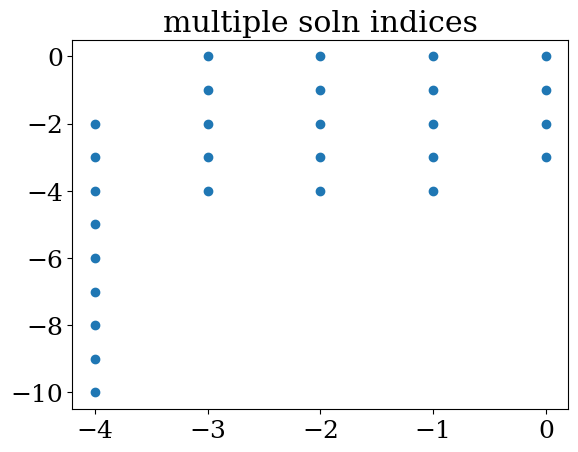

In [42]:
## mu values where multiple solutions exist. choosing minimum one
plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
plt.title("multiple soln indices")

<Figure size 640x480 with 0 Axes>

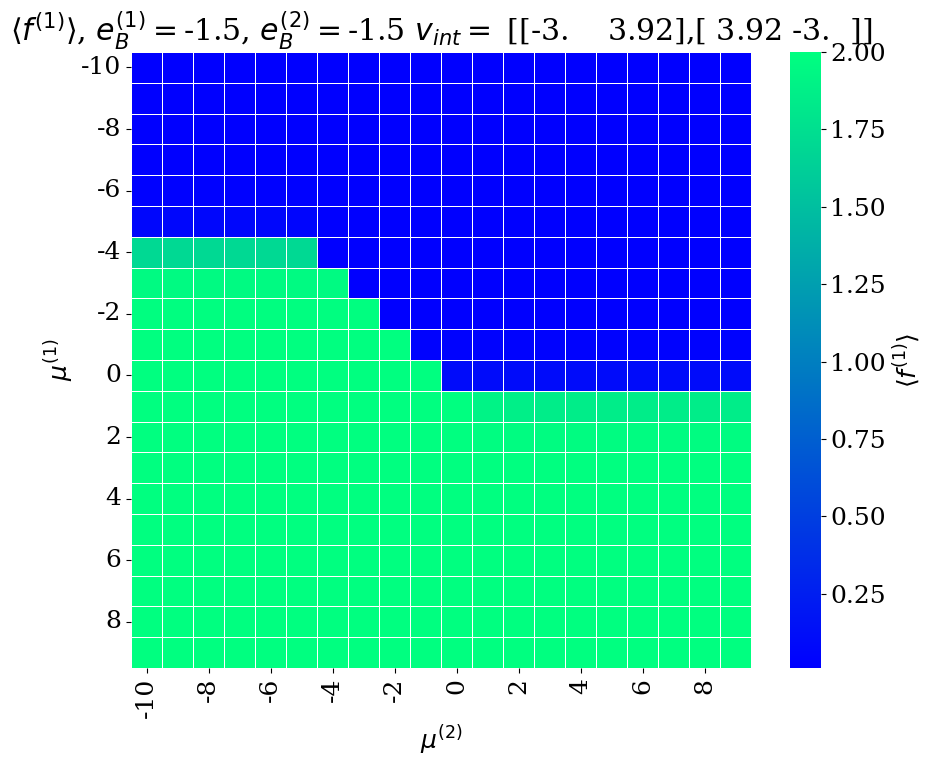

In [43]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])

# #protein 1
ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

# #protein 2
# ax = sns.heatmap(f_gam_soln_arr[1], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(2)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(2)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")



plt.show()


<Figure size 640x480 with 0 Axes>

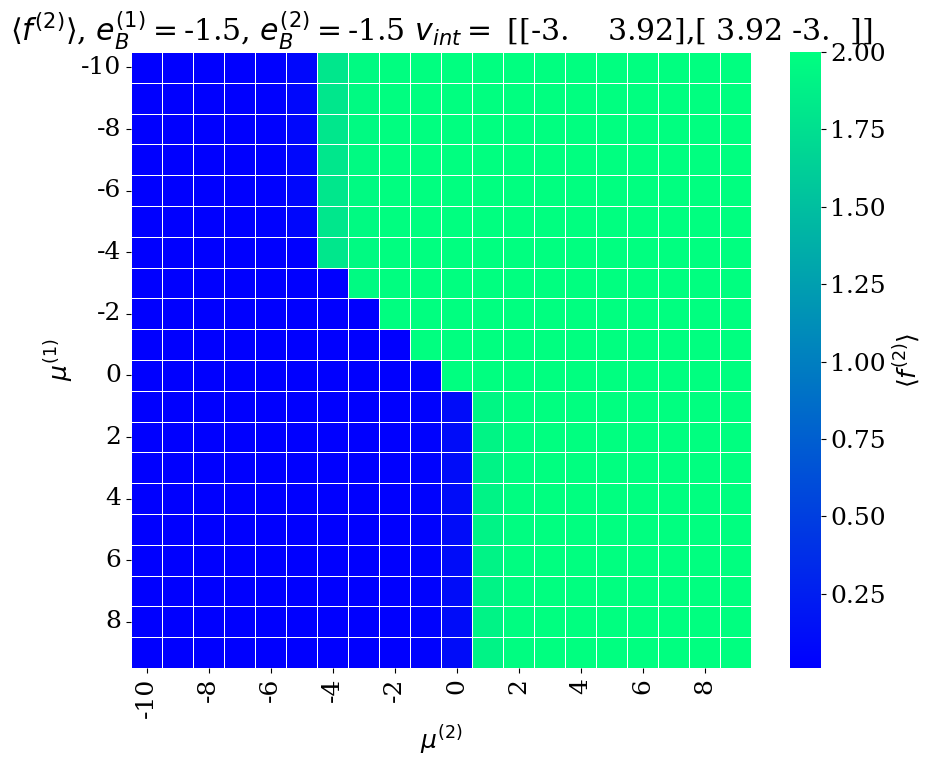

In [44]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])

# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

#protein 2
ax = sns.heatmap(f_gam_soln_arr[1], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(2)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ \langle f^{(2)} \rangle $" +  ", $e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")



plt.show()


## $\langle s_{i}^{(\gamma_1)} s_{j}^{(\gamma_1')} \rangle$ calculation

In [18]:
# TODO: need to consider possibiltiy of two solutions- need to compare free energy of higher and lower soln

mu = np.array([-2, -2])

f1 = f_gam_soln_arr[0][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
f2 = f_gam_soln_arr[1][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

f_bars = [f1, f2]
# s_bnd = np.zeros(6)
# for i in range(n_bind*3):
#     s_bnd[i] = s_bind_soln_arr[i][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
# s_bnd

# eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)

In [19]:
f_gam_soln_arr[0][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

2.0000000000000004

## sf2 calc

In [20]:
def calc_sf2_chromo(poly_marks, N_m, b, M2s, k_vec = np.logspace(-3, 2, 50)):
    M2_AA, M2_AB, M2_BA, M2_BB, M1_cgam0, M1_cgam1, M2_cc = M2s
#     print(k_vec[0])
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m
        
    grid = np.indices((M, M))
    j1 = grid[0]
    j2 = grid[1]

    S2_AA_arr = np.zeros(nk)
    S2_AB_arr = np.zeros(nk)
    S2_BA_arr = np.zeros(nk)
    S2_BB_arr = np.zeros(nk)
    
    S2_cgam0_arr = np.zeros(nk)
    S2_cgam1_arr = np.zeros(nk)
    S2_cc_arr = np.zeros(nk)

    for i, k in enumerate(k_vec):
        C = np.zeros((M, M))
        k = np.linalg.norm(k)
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2, s1 > s2
        index = (j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 
        
        C[np.where((index) != 0)] += debye
        
        #j1 > j2, s1 s2 any
        index = (j1 > j2)
        constant = np.exp(-x_m*(j1-j2))
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
        
        #j2 > j1, s1 s2 any
        index = (j2 > j1)
        constant = np.exp(-x_m*(j2-j1))
#         integral is the same

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral   
#         print(C/M**2)
        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)
        S2_AB_arr[i] = np.sum((1/M**2) * C * M2_AB)
        S2_BA_arr[i] = np.sum((1/M**2) * C * M2_BA)
        S2_BB_arr[i] = np.sum((1/M**2) * C * M2_BB)
        
        S2_cgam0_arr[i] = np.sum((1/M**2) * C * M1_cgam0)
        S2_cgam1_arr[i] = np.sum((1/M**2) * C * M1_cgam1)
        S2_cc_arr[i] = np.sum((1/M**2) * C * M2_cc)

    return S2_AA_arr*N**2, S2_AB_arr*N**2, S2_BA_arr*N**2, S2_BB_arr*N**2, S2_cgam0_arr*N**2, S2_cgam1_arr*N**2, S2_cc_arr*N**2


In [21]:
# f_bars

In [22]:
# s_bnd

In [23]:
%%time
# TODO: need to consider possibiltiy of two solutions- need to compare free energy (gen sfs) of higher and lower soln

mu = np.array([7, 7]) #chemical potential in solution

# k_vec = np.logspace(-3, 1, 30)
k_vec = np.logspace(-3, -1, 30)

f1 = f_gam_soln_arr[0][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
f2 = f_gam_soln_arr[1][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

f_bars = [f1, f2]

s_bnd = np.zeros(6)
for i in range(n_bind*3):
    s_bnd[i] = s_bind_soln_arr[i][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

#TODO confirm these indices are correct
indices_0 = np.tile(marks_1, (len(marks_1),1))#.T
# indices_0 = np.outer(marks_1, np.ones(len(marks_1)))
indices_1 = np.tile(marks_2, (len(marks_2),1)).T + 3
# indices_1 = np.outer(marks_2, np.ones(len(marks_2))) + 3

cc = np.ones((len(marks_1), len(marks_1)))

s_cgam0 = s_bnd[indices_0]
s_cgam1 = s_bnd[indices_1]

sisj_AA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)
sisj_AB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 1)
sisj_BA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 0)
sisj_BB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 1)
M2s = [sisj_AA,sisj_AB,sisj_BA,sisj_BB, s_cgam0, s_cgam1, cc]

[S2_AA_arr, S2_AB_arr, S2_BA_arr, S2_BB_arr, S2_cgam0_arr, S2_cgam1_arr, S2_cc_arr] = phi_c * np.array(calc_sf2_chromo(poly_marks, N_m, b, M2s, k_vec))

# [S2_AA_arr, S2_AB_arr, S2_BA_arr, S2_BB_arr, S2_cgam0_arr, S2_cgam1_arr, S2_cc_arr] = phi_c * np.array([S2_AA_arr, S2_AB_arr, S2_BA_arr, S2_BB_arr, S2_cgam0_arr, S2_cgam1_arr, S2_cc_arr] )
# np.round(sisj_AB,3) == np.round(sisj_BA.T, 3)

CPU times: total: 0 ns
Wall time: 3 ms


In [24]:
# sisj_AA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 1)
# sisj_AA_slow = slow_eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 1)
# sisj_AA == sisj_AA_slow

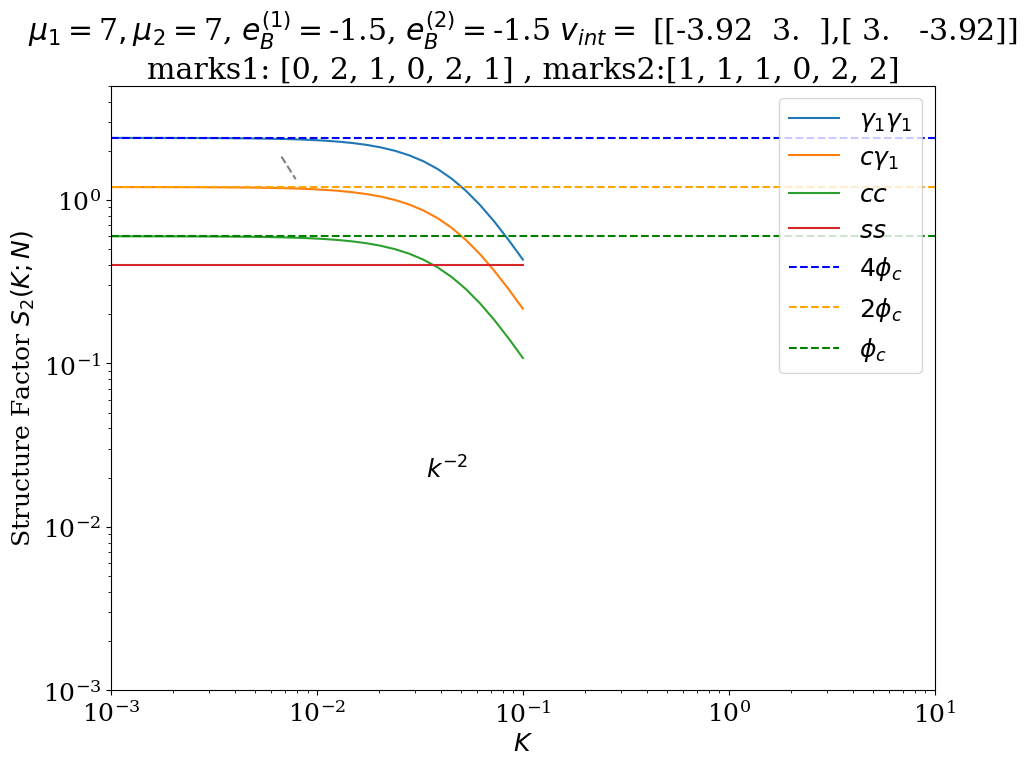

In [25]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
alh = 1
plt.plot(k_vec, S2_AA_arr/N**2, label = "$\gamma_1 \gamma_1$", linestyle = "-", alpha = alh)
# plt.plot(k_vec, S2_BB_arr/N**2, label = "g2g2", linestyle = "-", alpha = alh)
# plt.plot(k_vec, S2_AB_arr/N**2, label = "g1g2", linestyle = "--", alpha = alh)
# plt.plot(k_vec, S2_BA_arr/N**2, label = "g2g1", linestyle="--", alpha = alh)

plt.plot(k_vec, S2_cgam0_arr/N**2, label = "$c\gamma_1$", linestyle = "-")
# plt.plot(k_vec, S2_cgam1_arr/N**2, label = "cg2", linestyle = "--")
plt.plot(k_vec, S2_cc_arr/N**2, label = "$cc$", linestyle = "-")
plt.plot(k_vec, [1-phi_c]*len(k_vec), label = "$ss$", linestyle = "-")

plt.hlines(phi_c*4, 0.001, 100, color = "blue", linestyle = "--", label = "$4\phi_c$")
plt.hlines(phi_c*2, 0.001, 100, color = "orange", linestyle = "--", label = "$2\phi_c$")
plt.hlines(phi_c, 0.001, 100, color = "green", linestyle = "--", label = "$\phi_c$")
# plt.hlines(1-phi_c, 0.01, 100, color = "red", linestyle = "--", label = "$1-\phi_c$")

# low = 16
# high = 19
# plt.plot(k_vec[low:high], 0.5*k_vec[low:high]**-2/N**2, linestyle = "--", color = "grey")
# plt.plot(k_vec, 0.5*k_vec**-2/N**1, linestyle = "--", color = "grey")
# plt.text(.15, 7e-8, '$k^{-2}$')

low = 12
high = 14
plt.plot(k_vec[low:high], (0.5*k_vec[low:high]**-2/N**1 ), linestyle = "--", color = "grey")
plt.text(.034, 2e-2, '$k^{-2}$')



plt.xscale('log')
plt.yscale('log')

# plt.title("S2")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-3, 1e1))
plt.ylim((0.001, 5))

# plt.title("$v_{int} = $" + str(v_int) +  ", $e_B^{(1)} = $" + str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) + "$, \mu_1 = $" + str(mu[0]) \
#           + "$, \mu_2 = $" + str(mu[1]))

plt.title(r"$\mu_1 = $" + str(mu[0]) \
          + "$, \mu_2 = $" + str(mu[1]) +", $e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))

plt.tight_layout()
# plt.legend()
plt.legend(bbox_to_anchor=(1., 1.0))
plt.show()

## stability analysis

In [26]:
def signif(x, p):
    "converts every element in x to only p number of sig figs"
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

In [27]:
# k = 2
# chi = 1
# g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = calc_sf2_chromo(poly_marks, N_m, b, M2s, [k])
# g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = np.array([g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc])*phi_c
# ss = 1-phi_c
# S2_mat = 0.5 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                 [0, ss, 0, 0], \
#                 [cg1[0], 0, g1g1[0], g1g2[0]],\
#                 [cg2[0], 0, g2g1[0], g2g2[0]]])

# S2_inv = np.linalg.inv(S2_mat)

# # int_mat = np.array[[0,chi,0,0],\
# #                    [chi,0,0,0],\
# #                    [0,0,v_int[0,0], v_int[0,1]],\
# #                    [0,0,v_int[1,0], v_int[1,1]]]

# G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
#                [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
# # eigenvalue decomp
# val, vec = np.linalg.eigh(G2)
# val

In [28]:
# %env OPENBLAS_CORETYPE=SkylakeX

In [29]:
# random_diffdet = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# random_cond_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# for i, mu1 in enumerate(mu1_array[:]):
#     for j, mu2 in enumerate(mu2_array[:]):
#         mat = np.random.rand(3,3) * 1e8
#         npdet = np.linalg.det(mat)
#         mydet = get_det_3x3(mat)
#         random_diffdet[i][j] = (npdet - mydet)/ npdet
#         random_cond_arr[i][j] = np.linalg.cond(mat)

In [30]:
chi = 0

# min_eigval_arr = np.zeros((len(mu1_array), len(mu2_array), len(k_vec[:40:])))

min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:25:1])))
min_eigval_arr_soln1prot = np.zeros((len(mu1_array[:]),  len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt_singprot = np.zeros((len(mu1_array[:]),  len(mu2_array[:]), len(k_vec[:25:1])))

S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
S2_det_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# max_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:45:1])))

min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

melt_diffdet = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

S2_cond_max55 = 0
for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
#         print(mu)
        f1 = f_gam_soln_arr[0][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
        f2 = f_gam_soln_arr[1][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

        f_bars = [f1, f2]

        s_bnd = np.zeros(6)
        for ib in range(n_bind*3):
            s_bnd[ib] = s_bind_soln_arr[ib][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

        #TODO confirm these indices are correct
        indices_0 = np.tile(marks_1, (len(marks_1),1))#.T
        indices_1 = np.tile(marks_2, (len(marks_2),1)).T + 3

        cc = np.ones((len(marks_1), len(marks_1)))

        s_cgam0 = s_bnd[indices_0]
        s_cgam1 = s_bnd[indices_1]

        sisj_AA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)
        sisj_AB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 1)
        sisj_BA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 0)
        sisj_BB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 1)
        M2s = [sisj_AA,sisj_AB,sisj_BA,sisj_BB, s_cgam0, s_cgam1, cc]

#         N_m = 1
#         b = 1
#         N = N_m * np.shape(sisj_AA)[0]
#         print("mu: ", mu)
        for ik, k in enumerate(k_vec):
#             print("k:", k)
            g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_chromo(poly_marks, N_m, b, M2s, [k]))
#             g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = signif([g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc], 8)
            
#             #SOLUTION analysis
            ss = 1-phi_c
#             S2_mat = np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
            S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
                            [0, ss*N**2, 0, 0], \
                            [cg1[0], 0, g1g1[0], g1g2[0]],\
                            [cg2[0], 0, g2g1[0], g2g2[0]]])
        
# #             S2_mat =  N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
# #                             [0, ss, 0, 0], \
# #                             [cg1[0], 0, g1g1[0], g1g2[0]],\
# #                             [cg2[0], 0, g2g1[0], g2g2[0]]])
# #             print(S2_mat)
# #             print("det:", np.linalg.det(S2_mat))
            if phi_c >= 0.999:
                raise Exception("melt!")
            S2_det = np.linalg.det(S2_mat)

            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            S2_det_arr[i][j][ik] = S2_det
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
    #             G2 = N* np.array([[S2_inv[0,0] - 2*chi/N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
    #                [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]/N, S2_inv[2,3] + v_int[0,1]/N],\
    #                [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]/N, S2_inv[3,3] + v_int[1,1]/N]])

                G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])
    # #             det = np.linalg.det(G2)
    # #             det_arr[i][j][ik] = det
    # #             G2 = np.round(G2, 1)
                val, vec = np.linalg.eigh(G2)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val


#             max_eigval_arr[i][j][ik] = max_val  #use max because, if one eigval is positive,        
#             if ((mu1 == 0 and (mu2 == -2.5)) or (mu1 == -2.5 and (mu2 == 0))) and k == k_vec[0]:
#             if (((mu1 == 5 and (mu2 == 8)) or (mu1 == 8 and mu2 == 7)) and k == k_vec[0]):
            if ((mu1 == 5 and mu2 == 5) and k == k_vec[0]):
                if S2_cond > S2_cond_max55:
                    S2_cond_max55 = S2_cond
                print("[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")
                print("mu: ", mu)
                print("k = ", k)
                print("----------------------------")
                print("solution")
                print("S2: ", S2_mat)
                print("S2_inv: ", S2_inv)
                print("g2:", G2)
#                 print("det: ", det)
                print("vals: ", val)
#                 print("hehehehehehehehehehehehehehhehehehehehehehehehehehehehehehehee")
#                 print("new analysis, delg1 = delg2 incomp cond for symmetric system (mu1=mu2, eb1=eb2, marks1=marks2)")
#                 S2_mat = np.array([[cc[0], 0, 2*cg1[0]],\
#                                 [0, ss, 0], \
#                                 [2*cg1[0], 0, 4*g1g1[0]]])

#                 S2_inv = np.linalg.inv(S2_mat)
#                 G2 = S2_inv 
#                 det = np.linalg.det(G2)
#                 val, vec = np.linalg.eigh(G2)
#                 print("S2: ", S2_mat)
#                 print("g2:", G2)
# #                 print("det: ", det)
#                 print("vals: ", val)
# #             print(det)
 
#             if ((mu1 == 7 and (mu2 == 6 or mu2 == 7)) or (mu1 == -7 and (mu2 == -6 or mu2 == 7))) and k == k_vec[0]:
#             if ((mu1 == -10 and (mu2 == -1.5 or mu2 == -1)) and k == k_vec[0]):
#             if ((mu1 == -9.5 and (mu2 == -1.5 or mu2 == -1)) and k == k_vec[0]):
#                 print("[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")
#                 print("mu: ", mu)
#                 print("k = ", k)
#                 print("----------------------------")
#                 print("solution")
#                 print("S2: ", S2_mat)
#                 print("g2:", G2)
#                 print("det: ", det)
#                 print("vals: ", val)  





#             SOLUTION ONE READER PROTEIN v_int = 0000 chi = 0
#             print("H")
#             S2_mat = np.array([[cc[0], 0, cg1[0]],\
#                             [0, ss, 0], \
#                             [cg1[0], 0, g1g1[0]]])

#             S2_cond = np.linalg.cond(S2_mat)
#             S2_cond_arr_soln_1[i][j][ik] = S2_cond
#             det = np.linalg.det(S2_mat)
#             S2_det_arr[i][j][ik] = det
#             S2_inv = np.linalg.inv(S2_mat)
        
#             G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2]],\
#                [S2_inv[2,0], S2_inv[2,2]+v_int[0][0]]])
# #             det = np.linalg.det(G2)
# #             det_arr[i][j][ik] = det
# #             print(det)

#             val, vec = np.linalg.eigh(G2)

#             min_val = np.min(val)
#             min_eigval_arr_soln1prot[i][j][ik] = min_val

            
    
    
    
#             MELT analysis 2 reader proteins (BUT not really melt UNLESS rerun all with phi_c = 1)
#             if phi_c <= 0.999:
#                 raise Exception("solution!")            

#             S2_mat = 1/N**2 * np.array([[cc[0], cg1[0], cg2[0]],\
#                             [cg1[0], g1g1[0], g1g2[0]],\
#                             [cg2[0], g2g1[0], g2g2[0]]])


#             S2_mat = np.array([[cc[0], cg1[0], cg2[0]],\
#                             [cg1[0], g1g1[0], g1g2[0]],\
#                             [cg2[0], g2g1[0], g2g2[0]]])
#             S2_cond = np.linalg.cond(S2_mat)
#             S2_cond_arr_melt_2[i][j][ik] = S2_cond

#             npdet = np.linalg.det(S2_mat)
# #             mydet = get_det_3x3(S2_mat)
# #             melt_diffdet[i][j] = (npdet - mydet)/ npdet  
            
# #             cof = cofactors(S2_mat) # sign error!!
# #             det = get_det_3x3(S2_mat)
# #             inv = cof.T / det
# #             S2_inv = inv

#             S2_det_arr_melt[i][j][ik] = npdet#mydet#np.linalg.det(S2_mat)#det#



#             if npdet != 0:
#                 S2_inv = np.linalg.inv(S2_mat)
            
#                 G2 = N*S2_inv + \
#                 np.array([[0, 0, 0],\
#                    [0, v_int[0,0], v_int[0,1]],\
#                    [0,  v_int[1,0], v_int[1,1]]])
            
# #                 G2 = S2_inv + \
# #                 np.array([[0, 0, 0],\
# #                    [0, v_int[0,0], v_int[0,1]],\
# #                    [0,  v_int[1,0], v_int[1,1]]])
                
#                 val, vec = np.linalg.eigh(G2)

#                 min_val = np.min(val)

#                 min_eigval_arr_melt[i][j][ik] = min_val


#             if mydet != 0:
#                 S2_74 = S2_mat
#                 COF= np.array([[  S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1], -( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]),   S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]],\
#                               [  -(S2_74[0,1]*S2_74[2,2] - S2_74[0,2]*S2_74[2,1]),  S2_74[0,0]*S2_74[2,2] - S2_74[0,2]*S2_74[2,0] , -(S2_74[0,0]*S2_74[2,1] - S2_74[0,1]*S2_74[2,0])],\
#                               [  S2_74[0,1]*S2_74[1,2] - S2_74[0,2]*S2_74[1,1],  -(S2_74[0,0]*S2_74[1,2] - S2_74[0,2]*S2_74[1,0]), S2_74[0,0]*S2_74[1,1] - S2_74[0,1]*S2_74[1,0]]])

#                 ADJ = COF.T
#                 DET = mydet#S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]) - S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]) + S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0])
#                 S2_inv = ADJ/DET
                
# #                 S2_inv = signif(S2_inv, 4)
                
#                 G2 = S2_inv + \
#                 np.array([[0, 0, 0],\
#                    [0, v_int[0,0], v_int[0,1]],\
#                    [0,  v_int[1,0], v_int[1,1]]])
                
#                 val, vec = np.linalg.eigh(G2)

#                 min_val = np.min(val)

#                 min_eigval_arr_melt[i][j][ik] = min_val


# #             S2_inv_pre = S2_inv
# #             S2_inv = signif(S2_inv, 4)

#             G2 = S2_inv + \
#             np.array([[0, 0, 0],\
#                [0, v_int[0,0], v_int[0,1]],\
#                [0,  v_int[1,0], v_int[1,1]]])

#             part1 = S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1])

#             part2 = S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0])

#             part3 = S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0])

#             S2_part1_arr_melt[i][j][ik] = part1#det#
#             S2_part2_arr_melt[i][j][ik] = part2#det#
#             S2_part3_arr_melt[i][j][ik] = part3#det#

#             val, vec = np.linalg.eigh(G2)
#             if ((mu1 == -7 and (mu2 == 6 or mu2 == 7)) or (mu1 == 7 and (mu2 == -6 or mu2 == -7))) and k == k_vec[15]:
#             if ((mu1 == 0 and (mu2 == 0)) or (mu1 == 0 and (mu2 == 0))) and k == k_vec[0]:
#             if ((mu1 == 4 and (mu2 == -8)) or (mu1 == -8 and (mu2 == 4))) and k == k_vec[0]:
#             if ((mu1 == 6 and (mu2 == 9)) or (mu1 == 9 and (mu2 == 6))) and k == k_vec[0]:
#             if ((mu1 == -4 and (mu2 == -7)) or (mu1 == -7 and (mu2 == -4))) and k == k_vec[0]:
#             if ((mu1 == -8 and (mu2 == -10)) or (mu1 == -10 and (mu2 == -8))) and k == k_vec[0]:
#             if ((mu1 == 9 and (mu2 == 9)) or (mu1 == 9 and (mu2 == 9))) and k == k_vec[0]:
#                 print("[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[melt 2 reader prot]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")
# #                 print(cc[0])
#                 print("mu: ", mu)
#                 print("k = ", k)
#                 print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#                 print("melt")
#                 print("S2: ", S2_mat)
# #                 print("S2_inv pre: ", S2_inv_pre)
# #                 print("S2_inv psuedo: ", np.linalg.pinv(S2_mat))
#                 print("S2 det: ", np.linalg.det(S2_mat))
#                 det = get_det_3x3(S2_mat)

#                 print("HM S2 det: ", det)
#                 S2_74 = S2_mat
#                 part1 = signif(S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]), 10)
#                 print("shbld be zer: ", (S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]))
#                 print("part1: ", S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]) )
#                 print("part1: ", part1)
#                 part2 = signif(S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]), 10)
#                 print("part2: ", S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]))
#                 print("part2: ", part2)
#                 part3 = signif(S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]), 10)
#                 print("part3: ", S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]))
#                 print("part3: ", part3)
#                 print("DET!: ", part1-part2+part3)

#                 print("S2_inv: ", np.linalg.inv(S2_mat))

#                 print("S2_inv dot S2: ", np.dot(np.linalg.inv(S2_mat), S2_mat))
#                 print("S2_inv psuedo dot S2: ", np.dot(np.linalg.pinv(S2_mat), S2_mat))
#                 print("$$$$$$$$$$$ HOMEMADE $$$$$$$$$$")
#                 cof = cofactors(S2_mat)
#                 det = get_det_3x3(S2_mat)
#                 inv = cof.T / det
#                 print("cofactors: ", cof)
#                 print("HM S2_inv: ", inv)
#                 print("HM S2_inv dot S2: ", np.dot(inv,S2_mat))
#                 print("HM S2 det: ", det)

#                 print("g2:", np.round(G2,2))
#                 print("vals: ", np.linalg.eigh(np.round(G2,2))[0])
#                 print("g2:", G2)
#                 print("vals: ", val)

#             val, vec = np.linalg.eigh(G2)

#             min_val = np.min(val)
            
#             min_eigval_arr_melt[i][j][ik] = min_val
            
     
    
    
#             MELT analysis 1 reader protein (BUT not really melt UNLESS rerun all with phi_c = 1)
            

#             S2_mat = np.array([[cc[0], cg1[0]],\
#                               [cg1[0], g1g1[0]]])
# #             print("k: ", k)
# #             print(S2_mat)
#             S2_inv = np.linalg.inv(S2_mat)

#             G2 = S2_inv + \
#             np.array([[0, 0],\
#                [0, v_int[0,0]]])
            
#             val, vec = np.linalg.eigh(G2)
#             if ((mu1 == 7 and (mu2 == 6 or mu2 == 7)) or (mu1 == -7 and (mu2 == -6 or mu2 == -7))) and k == k_vec[15]:
#                 print("[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")
#                 print("mu: ", mu)
#                 print("k = ", k)
#                 print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#                 print("melt")
#                 print("S2: ", S2_mat)
#                 print("g2:", G2)
#                 print("vals: ", val)

#             min_val = np.min(val)
            
#             min_eigval_arr_melt_singprot[i][j][ik] = min_val
        

    
    
#             MELT analysis 1 reader protein (other protein) (BUT not really melt UNLESS rerun all with phi_c = 1)
            
#             S2_mat = np.array([[cc[0], cg2[0]],\
#                               [cg2[0], g2g2[0]]])
# #             print("k: ", k)
# #             print(S2_mat)
#             S2_inv = np.linalg.inv(S2_mat)

#             G2 = S2_inv + \
#             np.array([[0, 0],\
#                [0, v_int[1,1]]])
            
#             val, vec = np.linalg.eigh(G2)
#             if ((mu1 == 7 and (mu2 == 6 or mu2 == 7)) or (mu1 == -7 and (mu2 == -6 or mu2 == -7))) and k == k_vec[15]:
#                 print("[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")
#                 print("mu: ", mu)
#                 print("k = ", k)
#                 print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#                 print("melt")
#                 print("S2: ", S2_mat)
#                 print("g2:", G2)
#                 print("vals: ", val)

#             min_val = np.min(val)
            
#             min_eigval_arr_melt_singprot[i][j][ik] = min_val
        

    
    
#             # POLY/SOLV only, no binding analysis 
            
#             ss = 1-phi_c
#             S2_mat = np.array([[cc[0], 0], [0, ss]])
            
#             S2_inv = np.linalg.inv(S2_mat)

#             G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])
            
#             val = G2[0]#vec = np.linalg.eigh(G2)
            
#             if mu1 == 7 and (mu2 == 6 or mu2 == 7) and k == k_vec[0]:
#                 print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#                 print("poly solv no binding")
#                 print("S2: ", S2_mat)
#                 print("g2:", G2)
#                 print("vals: ", val)
                
#             min_eigval_arr_ps[i][j][ik] = val
#             if min_val <= 0

        # all-k analysis
#         min_vals = min_eigval_arr[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#         minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks

        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
            min_eigval_arr_allk[i][j] = minval_allk
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
            k_star_arr[i][j] = k_star


        min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
        minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
        min_eigval_arr_allk_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
#         print(k_star)
#         k_star_arr[i][j] = k_star
#         print("gf")

[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
mu:  [5, 5]
k =  0.001
----------------------------
solution
S2:  [[0.59980005 0.         1.19956754 1.19957099]
 [0.         0.4        0.         0.        ]
 [1.19956754 0.         2.39906994 2.39907686]
 [1.19957099 0.         2.39907686 2.39908377]]
S2_inv:  [[ 4.04721219e+14  0.00000000e+00 -2.21370209e+14  1.90040509e+13]
 [ 0.00000000e+00  2.50000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.22811347e+14 -0.00000000e+00  2.09680167e+14 -9.82711864e+13]
 [ 2.04451849e+13 -0.00000000e+00 -9.89917730e+13  8.87686472e+13]]
g2: [[ 6.74535365e+10 -3.68950348e+10  3.16734181e+09]
 [-3.71352245e+10  3.49466945e+10 -1.63785311e+10]
 [ 3.40753082e+09 -1.64986288e+10  1.47947745e+10]]
vals:  [-5.34634319e+07  2.36798957e+10  9.35685733e+10]


In [41]:
np.sign(-40)

-1

<Figure size 640x480 with 0 Axes>

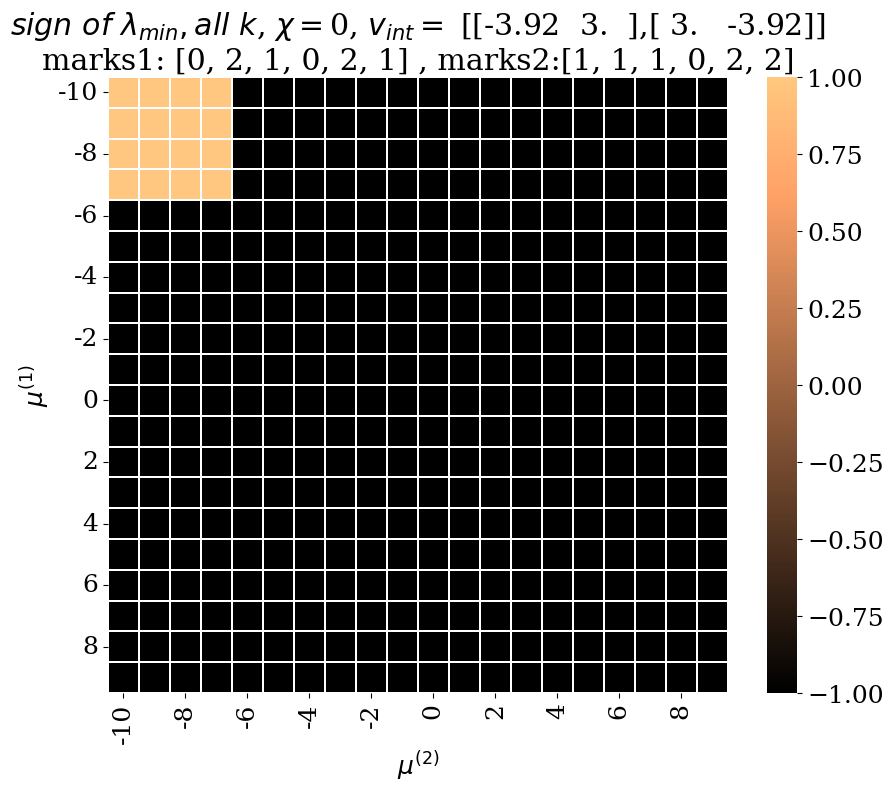

In [31]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [32]:
b

1

<Figure size 640x480 with 0 Axes>

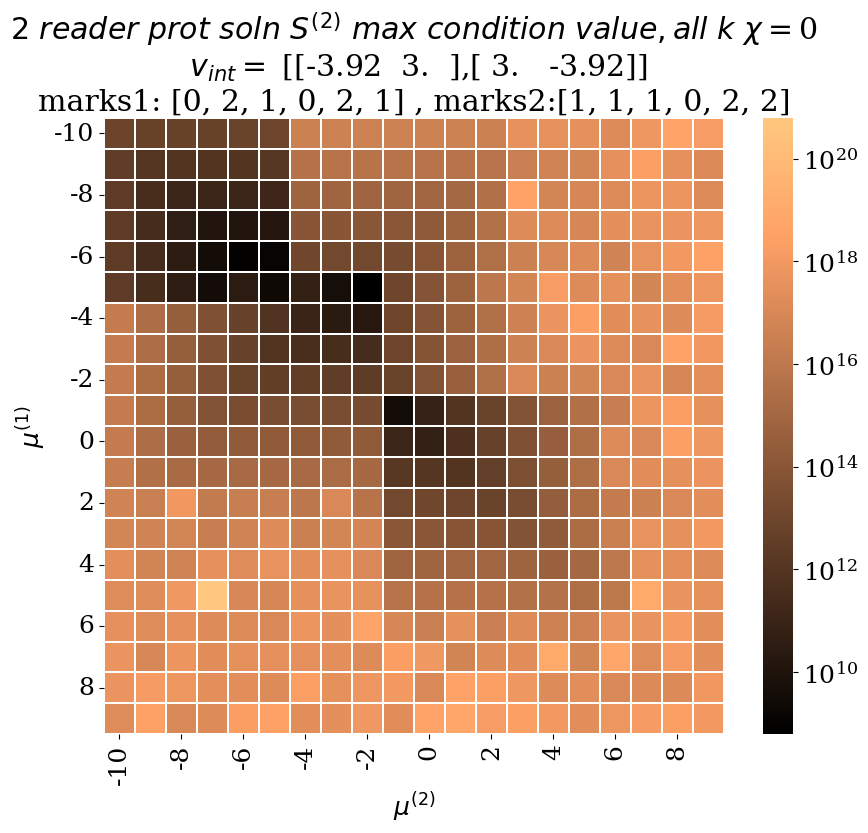

In [33]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
ax = sns.heatmap(max_cond_arr_allk, linewidth=0.25, norm=LogNorm(), cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 2 \ reader \ prot \ soln \  S^{(2)} \ max \ condition \ value, all \  k \  \chi = $" + \
          str(chi)+\
          "\n" +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))

plt.show()


<Figure size 640x480 with 0 Axes>

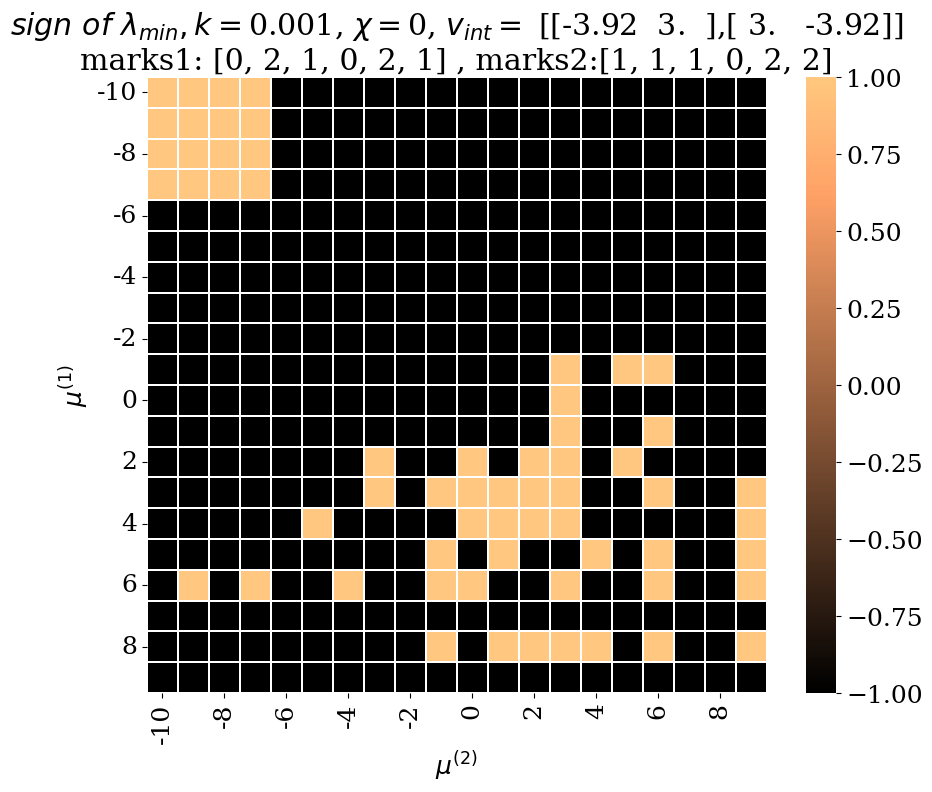

In [34]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


<Figure size 640x480 with 0 Axes>

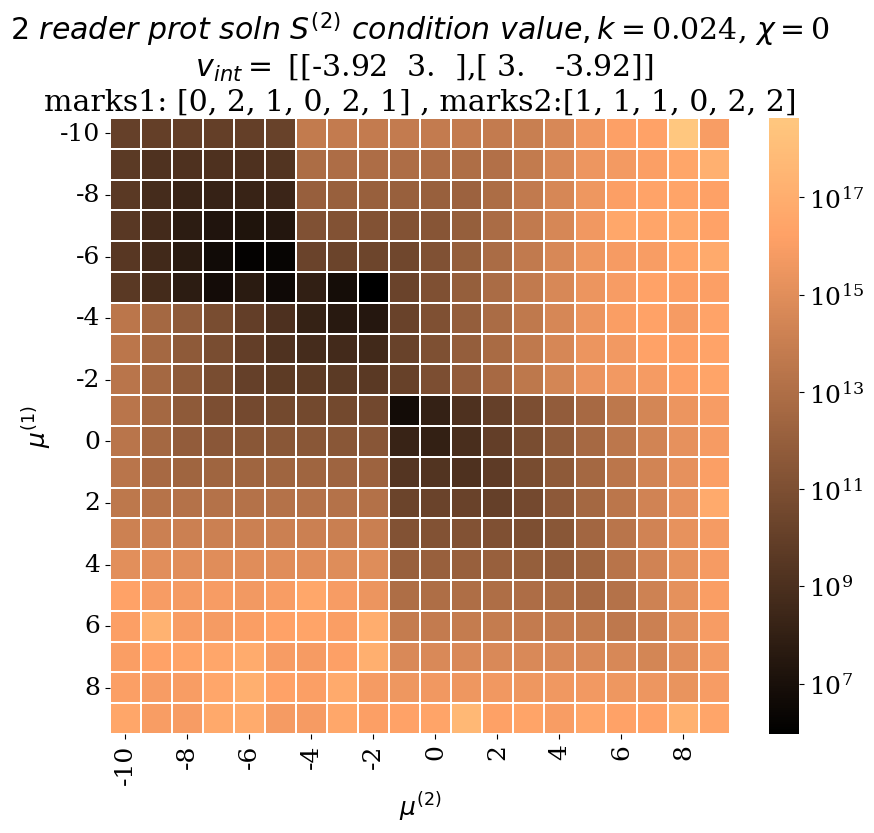

In [35]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 20
ax = sns.heatmap(S2_cond_arr_soln_2[:,:,k_ind], linewidth=0.25, norm=LogNorm(), cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 2 \ reader \ prot \ soln \  S^{(2)} \ condition \ value, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi)+\
          "\n" +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))

plt.show()


<Figure size 640x480 with 0 Axes>

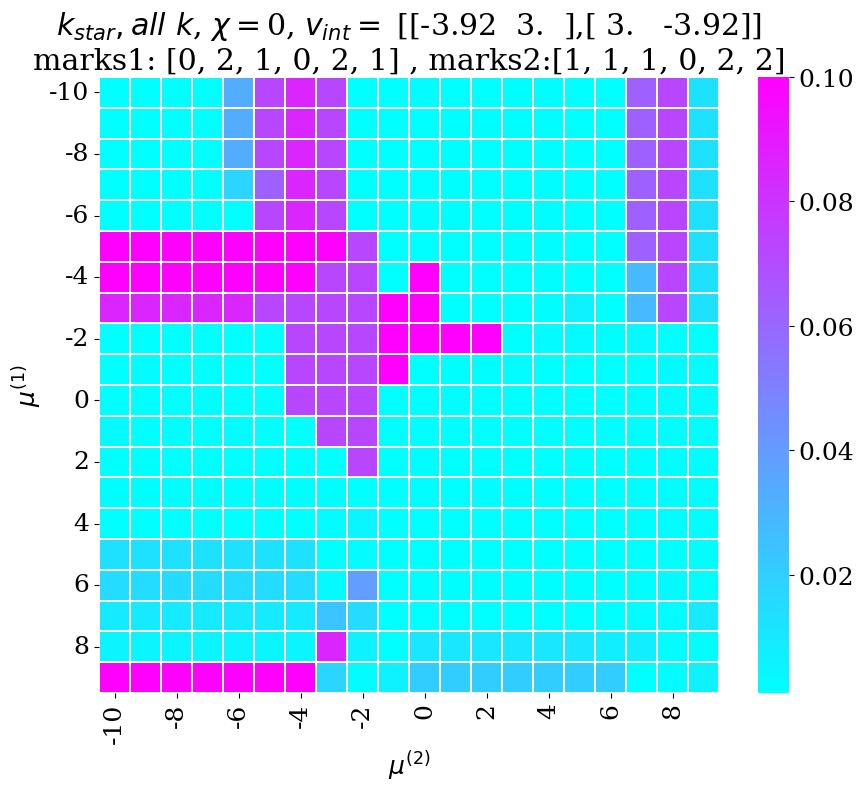

In [36]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(k_star_arr, linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ k_{star}, all \ k$" +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
# MELT PLOTS

In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk_melt), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ MELT \ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr_melt[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ MELT \  sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(S2_cond_arr_melt_2[:,:,k_ind], linewidth=0.25, norm=LogNorm(), cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ MELT \  S^{(2)} \ condition \ value, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
# S2_74 = np.array([[1.59114803e+07, 7.92580890e+04, 1.49320316e+06],\
#                  [7.92580890e+04, 3.95240300e+02, 7.42985215e+03],\
#                  [1.49320316e+06, 7.42985215e+03, 1.40276665e+05]])
S2_74 = S2 = np.array([[9.91666667e-01, 2.46805556e-04, 2.72777778e-04],\
 [2.46805556e-04 ,6.14166667e-08, 6.78888889e-08],
 [2.72777778e-04, 6.78888889e-08, 7.50555556e-08]])
COF= np.array([[  S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1], -( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]),   S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]],\
              [  -(S2_74[0,1]*S2_74[2,2] - S2_74[0,2]*S2_74[2,1]),  S2_74[0,0]*S2_74[2,2] - S2_74[0,2]*S2_74[2,0] , -(S2_74[0,0]*S2_74[2,1] - S2_74[0,1]*S2_74[2,0])],\
              [  S2_74[0,1]*S2_74[1,2] - S2_74[0,2]*S2_74[1,1],  -(S2_74[0,0]*S2_74[1,2] - S2_74[0,2]*S2_74[1,0]), S2_74[0,0]*S2_74[1,1] - S2_74[0,1]*S2_74[1,0]]])

ADJ = COF.T
DET = S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]) - S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]) + S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0])
INV = ADJ/DET
np.dot(S2_74, INV)

In [ ]:
S2 = np.array( [[0.99446752, 1.31028502, 1.96700071],\
 [1.31028502 ,1.7266765  ,2.59165773],\
 [1.96700071 ,2.59165773 ,3.8906171 ]])
# np.linalg.det(S2)

S2_74 = S2
part1 = signif( S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]), 10)
print("part1: ", S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]) )
print("part1: ", part1)
part2 = signif(S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]), 10)
print("part2: ", S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]))
print("part2: ", part2)
part3 = signif(S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]), 10)
print("part3: ", S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]))
print("part3: ", part3)
print(part1-part2+part3)

In [ ]:
marks_1

In [ ]:
S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1])

In [ ]:
mu1_array

In [ ]:
# melt only test analysis
chi = 0

min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

k_vec = [0.001]

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
#         print(mu)
        f1 = f_gam_soln_arr[0][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
        f2 = f_gam_soln_arr[1][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

        f_bars = [f1, f2]

        s_bnd = np.zeros(6)
        for b in range(n_bind*3):
            s_bnd[b] = s_bind_soln_arr[b][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

        #TODO confirm these indices are correct
        indices_0 = np.tile(marks_1, (len(marks_1),1))#.T
        indices_1 = np.tile(marks_2, (len(marks_2),1)).T + 3

        cc = np.ones((len(marks_1), len(marks_1)))

        s_cgam0 = s_bnd[indices_0]
        s_cgam1 = s_bnd[indices_1]

        sisj_AA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)
        sisj_AB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 1)
        sisj_BA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 0)
        sisj_BB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 1)
        M2s = [sisj_AA,sisj_AB,sisj_BA,sisj_BB, s_cgam0, s_cgam1, cc]

        for ik, k in enumerate(k_vec):
            g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_chromo(poly_marks, N_m, b, M2s, [k]))
    
#             MELT analysis 2 reader proteins (BUT not really melt UNLESS rerun all with phi_c = 1)
            
            S2_mat = np.array([[cc[0], cg1[0], cg2[0]],\
                            [cg1[0], g1g1[0], g1g2[0]],\
                            [cg2[0], g2g1[0], g2g2[0]]])
#             S2_mat =  1/N**2 * np.array([[cc[0], cg1[0], cg2[0]],\
#                             [cg1[0], g1g1[0], g1g2[0]],\
#                             [cg2[0], g2g1[0], g2g2[0]]])
            S2_cond = np.linalg.cond(S2_mat)
#             print("k: ", k)
#             print(S2_mat)
            S2_inv = np.linalg.inv(S2_mat)
#             S2_inv_pre = S2_inv
#             S2_inv = signif(S2_inv, 4)
            G2 = S2_inv + \
            np.array([[0, 0, 0],\
               [0, v_int[0,0], v_int[0,1]],\
               [0,  v_int[1,0], v_int[1,1]]])
            S2_cond_arr_melt_2[i][j][ik] = S2_cond

            val, vec = np.linalg.eigh(G2)
#             if ((mu1 == -7 and (mu2 == 6 or mu2 == 7)) or (mu1 == 7 and (mu2 == -6 or mu2 == -7))) and k == k_vec[15]:
#             if ((mu1 == 2 and (mu2 == -2)) or (mu1 == -2 and (mu2 == 2))) and k == k_vec[0]:
#             if ((mu1 == 4 and (mu2 == -8)) or (mu1 == -8 and (mu2 == 4))) and k == k_vec[0]:
#             if ((mu1 == 8 and (mu2 == 9)) or (mu1 == 9 and (mu2 == 8))) and k == k_vec[0]:
#             if ((mu1 == -4 and (mu2 == -7)) or (mu1 == -7 and (mu2 == -4))) and k == k_vec[0]:
#             if ((mu1 == -2 and (mu2 == 0)) or (mu1 == 0 and (mu2 == -2))) and k == k_vec[0]:
            if ((mu1 == -10 and (mu2 == -10)) or (mu1 == 9 and (mu2 == 9))) and k == k_vec[0]:
#             if ((mu1 == 9 and (mu2 == -10)) or (mu1 == -10 and (mu2 == 9))) and k == k_vec[0]:
#                 print("[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[melt 2 reader prot]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")
#                 print(cc[0])
                print("mu: ", mu)
                print("k = ", k)
                print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
                print("melt")
                print("S2: ", S2_mat)
#                 print("S2_inv pre: ", S2_inv_pre)
#                 print("S2_inv psuedo: ", np.linalg.pinv(S2_mat))
                print("S2_inv: ", S2_inv)

                print("S2_inv dot S2: ", np.dot(np.linalg.inv(S2_mat), S2_mat))
#                 print("S2_inv psuedo dot S2: ", np.dot(np.linalg.pinv(S2_mat), S2_mat))
#                 print("S2 det: ", np.linalg.det(S2_mat))
                print("vals:", val)
#                 print("$$$$$$$$$$$ HOMEMADE $$$$$$$$$$")
#                 cof = cofactors(S2_mat)
#                 det = get_det_3x3(S2_mat)
#                 inv = cof.T / det
#                 print("HM S2_inv: ", inv)
#                 print("HM S2_inv dot S2: ", np.dot(inv,S2_74))
#                 print("HM S2 det: ", det)
#                 S2_74 = S2_mat
#                 print(S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]) - S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]) + S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]))
#                 part1 = signif(S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]), 10)
#                 print("part1: ", S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]) )
#                 print("part1: ", part1)
#                 part2 = signif(S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]), 10)
#                 print("part2: ", S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]))
#                 print("part2: ", part2)
#                 part3 = signif(S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]), 10)
#                 print("part3: ", S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]))
#                 print("part3: ", part3)
#                 print("DET!: ", part1-part2+part3)
# #                 print("g2:", np.round(G2,2))
# #                 print("vals: ", np.linalg.eigh(np.round(G2,2))[0])
#                 print("g2:", G2)
#                 print("vals: ", val)
        
            min_val = np.min(val)
            
            min_eigval_arr_melt[i][j][ik] = min_val
            


In [ ]:
S2_74 = np.array([[1.59114803e+07, 7.92580890e+04, 1.49320316e+06],\
                 [7.92580890e+04, 3.95240300e+02, 7.42985215e+03],\
                 [1.49320316e+06, 7.42985215e+03, 1.40276665e+05]])

COF= np.array([[  S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1], -( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]),   S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]],\
              [  -(S2_74[0,1]*S2_74[2,2] - S2_74[0,2]*S2_74[2,1]),  S2_74[0,0]*S2_74[2,2] - S2_74[0,2]*S2_74[2,0] , -(S2_74[0,0]*S2_74[2,1] - S2_74[0,1]*S2_74[2,0])],\
              [  S2_74[0,1]*S2_74[1,2] - S2_74[0,2]*S2_74[1,1],  -(S2_74[0,0]*S2_74[1,2] - S2_74[0,2]*S2_74[1,0]), S2_74[0,0]*S2_74[1,1] - S2_74[0,1]*S2_74[1,0]]])

ADJ = COF.T
DET = S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]) - S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]) + S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0])
INV = ADJ/DET

In [ ]:
def cofactors(A):
    U,sigma,Vt = np.linalg.svd(A)
    N = len(sigma)
    g = np.tile(sigma,N)
    g[::(N+1)] = 1
    G = np.diag(-(-1)**N*np.product(np.reshape(g,(N,N)),1)) 
    return (U @ G @ Vt)

In [ ]:
def get_det_3x3(S2_74):
#     DET = signif(S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]), 4)\
#     - signif(S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]), 4)\
#     + signif(S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]), 4)
    
    DET = S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1])\
    - S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0])\
    + S2_74[0,2]*(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0])
    
#     print("part1 getdet: ", S2_74[0,0]*(S2_74[1,1]*S2_74[2,2] - S2_74[1,2]*S2_74[2,1]))
#     print("part2 getdet: ",  S2_74[0,1]*( S2_74[1,0]*S2_74[2,2] - S2_74[1,2]*S2_74[2,0]))
#     print("part3 getdet: ",  S2_74[0,2] *(S2_74[1,0]*S2_74[2,1] - S2_74[1,1]*S2_74[2,0]))

    return DET

In [ ]:
g2 = np.array([[ 4.18906449e+08, -3.65577336e+08, -2.22268672e+08],\
 [-3.65577336e+08,  3.19037316e+08,  1.93972638e+08],\
 [-2.22268672e+08,  1.93972638e+08,  1.17934118e+08]])
np.linalg.eigh(np.round(g2,1))

In [ ]:
g2 = np.array([[ 4.18906449e+08, -2.22268672e+08, -3.65577336e+08],\
 [-2.22268672e+08,  1.17934118e+08,  1.93972638e+08],\
 [-3.65577336e+08,  1.93972638e+08,   3.19037316e+08]])
np.linalg.eigh(g2)

In [ ]:
6.41779130e-02*N

In [ ]:
g2 = N*np.array([[ 4.18906449e+08, -2.22268672e+08, -3.65577336e+08],\
 [-2.22268672e+08,  1.17934118e+08,  1.93972638e+08],\
 [-3.65577336e+08,  1.93972638e+08,   3.19037316e+08]])
np.linalg.eigh(g2)

In [ ]:
# #density maps
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 0
# ax = sns.heatmap(min_eigval_arr[:,:,k_ind], linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# # ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# # protein 1
# # ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
#           str(chi) \
#           +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")


# plt.show()


In [ ]:
N

In [ ]:

#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.abs(melt_diffdet[:,:,0]), linewidth=0.25, cmap = "cool", norm=LogNorm(), xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ S2 \ melt\  matrix \ | \frac{my \ det \ - np.linalg.det}{np.linalg.det} |, $" + "$k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()

In [ ]:
np.max(random_diffdet)

In [ ]:

#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.abs(random_diffdet[:,:]), linewidth=0.25, cmap = "cool", norm=LogNorm())
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ random \ matrix \ | \frac{my \ det \ - np.linalg.det}{np.linalg.det} |, $")


plt.show()

In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 10
ax = sns.heatmap(S2_det_arr[:,:,k_ind], linewidth=0.25, cmap = "hot", norm=LogNorm(), xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 2 \ prot \ soln |S_2 |, $" + "$k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 10
# ax = sns.heatmap(np.abs(S2_det_arr_melt[:,:,k_ind]), linewidth=0.25, cmap = "cool", norm=LogNorm(), xticklabels=mu2_array, yticklabels=mu1_array)
ax = sns.heatmap(S2_det_arr_melt[:,:,k_ind], linewidth=0.25, cmap = "cool", norm=LogNorm(), xticklabels=mu2_array, yticklabels=mu1_array)
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 2 \ protein \ melt \ |S_2 |$, " + "$k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
det_error = np.abs(np.abs(S2_det_arr_melt[:,:,k_ind]) - np.abs(S2_det_arr_melt[:,:,k_ind].T))
ax = sns.heatmap(det_error, linewidth=0.25, cmap = "cool", norm=LogNorm(), xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 2 \ protein \ melt \ \Delta |S_2 |, np.linalg.det, $" + "$k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
det_error[10][12]

In [ ]:
S2_det_arr_melt[10,12,k_ind]

In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
det_error = np.abs(np.abs(S2_det_arr_melt[:,:,k_ind]) - np.abs(S2_det_arr_melt[:,:,k_ind].T))

# ax = sns.heatmap(S2_det_arr_melt[:,:,k_ind]/det_error, linewidth=0.25, cmap = "cool", norm=LogNorm(), xticklabels=mu2_array, yticklabels=mu1_array)
ax = sns.heatmap(np.abs(det_error/S2_det_arr_melt[:,:,k_ind]), linewidth=0.25, cmap = "cool", norm=LogNorm(), xticklabels=mu2_array, yticklabels=mu1_array)

# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 2 \ protein \ melt \ |S_2 | div \Delta |S_2 |, np.linalg.det, $" + "$k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(k_star_arr, linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ k_{star}, all \ k$" +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
# min_eigval_arr_allk

In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk_melt), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ MELT \ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
N

In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr_ps[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ POLY/SOLV \  sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr_soln1prot[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ Single \ reader \ prot \ soln \  sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi)+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr_melt_singprot[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ Single \ reader \ prot \ MELT \  sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi)+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(np.sign(min_eigval_arr_melt[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ MELT \  sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))


plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 10
ax = sns.heatmap(S2_cond_arr_soln_2[:,:,k_ind], linewidth=0.25, norm=LogNorm(), cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 2 \ reader \ prot \ soln \  S^{(2)} \ condition \ value, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi)+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))

plt.show()


In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(S2_cond_arr_soln_1[:,:,k_ind], linewidth=0.25, norm=LogNorm(), cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ Single \ reader \ prot \ soln \  S^{(2)} \ condition \ value, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi)+\
          "\n" "marks1: " + str(marks_1) + " , marks2:" + str(marks_2))

plt.show()


In [ ]:
np.min(S2_cond_arr_melt_2)

In [ ]:
S2_cond_arr_melt_2[:,:,k_ind]

In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 0
ax = sns.heatmap(random_cond_arr[:,:], linewidth=0.25, norm=LogNorm(), cmap = "copper")
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})


plt.title(r"$ random \  mat \ condition \ value$")


plt.show()


In [ ]:
S2_cond_arr[0][1][0]

In [ ]:
# WHAT IS UNIQUE ABOUT THOSE stable points. Look at what changes when crossing over from mu = 7,7 to mu = 7,6

In [ ]:
import sympy as sym
cc, ss, cg1, cg2, g1g1, g1g2, g2g1, g2g2 = sym.symbols("cc, ss, cg1, cg2, g1g1, g1g2, g2g1, g2g2")
# M = sym.Matrix([[cc, 0, cg1, cg1],\
#                 [0, ss, 0, 0], \
#                 [cg1, 0, g1g1, g1g1],\
#                 [cg1, 0, g1g1, g1g1]])
# Minv = M.inv()
# Minv.applyfunc(sym.simplify)

# applying delt g1 = delt g2 for sym sys
M = sym.Matrix([[cc, 0, 2*cg1],\
                [0, ss, 0,], \
                [2*cg1, 0, 4*g1g1]])
Minv = M.inv()
Minv.applyfunc(sym.simplify)
Minv.eigenvals()

In [ ]:
cc, ss, cg1, cg2, g1g1, g1g2, g2g1, g2g2 = sym.symbols("cc, ss, cg1, cg2, g1g1, g1g2, g2g1, g2g2")
M = sym.Matrix([[cc, 0, cg1, cg2],\
                [0, ss, 0, 0], \
                [cg1, 0, g1g1, g1g2],\
                [cg2, 0, g1g2, g2g2]])
Minv = M.inv()
Minv.applyfunc(sym.simplify)

In [ ]:
# # poly/solv key analysis

# def gam2_polysolv(poly_marks, N_m, b, M2s, k):
#     g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_chromo(poly_marks, N_m, b, M2s, k))    
#     ss = 1-phi_c
#     S2_mat = np.array([[cc[0], 0], [0, ss]])

#     S2_inv = np.linalg.inv(S2_mat)
#     chi = 0
#     G2 = np.array([N*S2_inv[0,0] - 2*chi + N*S2_inv[1,1]])
#     return G2

# KS = opt.fmin(lambda K: np.real(gam2_polysolv(poly_marks, N_m, b, M2s, [k])), 0.001,\
#                   disp=False)
# KS

# #solvent strucutre afctor normailization wrong, but still getting stability of mixed system at chi = 0
# chi = 0

# k = 0.001
# g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_chromo(poly_marks, N_m, b, M2s, [k]))

# ss = 1-phi_c

# S2_mat = np.array([[cc[0], 0], [0, 1*ss]])
# S2_mat = np.array([[cc[0], 0, 0.0001], [0, 1*ss, 0.0001], [0,0,0.0001]]) #proof of concept
# # S2_mat = np.array([[cc[0], 0, 0.0001], [0, 100000*ss, 0.0001], [0,0,0.0001]]) #goal
# # S2_mat = np.array([[cc[0], 0, 0.01], [0, 0.00001*ss, 0.01], [0,0,0.01]]) # current

# S2_inv = np.linalg.inv(S2_mat)

# G2 = np.array([N*S2_inv[0,0] - 2*chi + N*S2_inv[1,1]])

# val = G2[0]#vec = np.linalg.eigh(G2)
# print(val)

# ss = 1-phi_c
# cc = phi_c
# cg1 = 2*phi_c
# cg2 = cg1
# g1g1 = 4*phi_c
# g1g2 = g1g1
# g2g1 = g1g1
# g2g2 = g1g1


# S2_mat = N**2 * np.array([[cc, 0, cg1, cg2],\
#                 [0, ss/N**2, 0, 0], \
#                 [cg1, 0, g1g1, g1g2],\
#                 [cg2, 0, g2g1, g2g2]])
# print(S2_mat)
# # S2_inv = np.linalg.inv(S2_mat)

# # G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
# #    [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
# #    [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])


# #melt
# # S2_mat = N**2 * np.array([[cc, cg1, cg2],\
# #                 [cg1, g1g1, g1g2],\
# #                 [cg2, g2g1, g2g2]])

# s2melt = np.array([[21.59928454,43.17493707,43.17493707],
#  [43.17493707, 86.39522506, 86.3952214 ],
#  [43.17493707, 86.3952214,  86.39522506]])


# print(s2melt, "Poo")
# S2_inv = np.linalg.inv(s2melt)

# val, vec = np.linalg.eigh(S2_inv)
# print(min(val))
# # G2 = np.array([[S2_inv[0,0], S2_inv[0,1], S2_inv[0,]],\
# #    [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
# #    [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])

# # val, vec = np.linalg.eigh(G2)

In [ ]:
# # 1D solution plotting
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)
    

# # f_bar (single solns ONLY): 
# plt.plot(mu1_array, f_gam_soln_arr[0][:,9], label = r"$ \langle f_{\gamma}^{(1)} \rangle $", color = "blue")
# plt.plot(mu2_array, f_gam_soln_arr[1][6,:], label = r"$ \langle f_{\gamma}^{(2)} \rangle $", color = "green", linestyle = "--")


# # s_bind:
# # plt.plot(mu1_array, s_bind_soln_arr[0][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 0)} \rangle $",)
# # plt.plot(mu1_array, s_bind_soln_arr[1][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 1)} \rangle $",)
# # plt.plot(mu1_array, s_bind_soln_arr[2][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 2)} \rangle $",)

# # plt.plot(mu2_array, s_bind_soln_arr[3][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 0)} \rangle $",)
# # plt.plot(mu2_array, s_bind_soln_arr[4][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 1)} \rangle $",)
# # plt.plot(mu2_array, s_bind_soln_arr[5][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 2)} \rangle $",)


# # # LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
# # K = np.exp(-e_m[0])
# # plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir", linestyle = ":", color = "black")

# # K = np.exp(-0)  # sigma = 0 - all binding energies are 0
# # plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")


# plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel("$\mu^{(n)} $")
# plt.title(r"$e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
# plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# # plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
# plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
# plt.legend()

# # why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
# #check solver- intial conditions? 

In [ ]:
# # self-consistent calculation plotting

# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)


# ax = plt.axes(projection='3d')

# X,Y = np.meshgrid(f_gam_arr,f_gam_arr)

# # ax.view_init(0,0)
# # ax.contour3D(X, Y, RHS_arr[0], 100, cmap='rainbow', label = r"$ \langle f_{\gamma_1} \rangle $ RHS")
# # ax.contour3D(X, Y, Y, 50, cmap='binary', label = r"$ \langle f_{\gamma_1} \rangle $ LHS")
# # rainbow_patch = matplotlib.patches.Patch(color='red', label=r"$ \langle f_{\gamma_1} \rangle $ RHS")
# # black_patch = matplotlib.patches.Patch(color='grey', label=r"$ \langle f_{\gamma_1} \rangle $ LHS")
# # #ax.contour3D(X, Y, RHS_arr[0]-Y, 50, cmap='binary')

# ax.view_init(0,-90)
# ax.contour3D(X, Y, RHS_arr[1], 50, cmap='rainbow', label = r"$ \langle f_{\gamma_2} \rangle $ RHS")
# ax.contour3D(X, Y, X, 50, cmap='binary', label = r"$ \langle f_{\gamma_2} \rangle $ LHS")
# rainbow_patch = matplotlib.patches.Patch(color='red', label=r"$ \langle f_{\gamma_2} \rangle $ RHS")
# black_patch = matplotlib.patches.Patch(color='grey', label=r"$ \langle f_{\gamma_2} \rangle $ LHS")
# # #ax.contour3D(X, Y, RHS_arr[1]-X, 50, cmap='binary')

# ax.set_xlabel(r"$ \langle f_{\gamma_2} \rangle $")
# ax.set_ylabel(r"$ \langle f_{\gamma_1} \rangle $")
# # ax.set_zlabel('z')

# # plt.xlabel()
# # plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $,e_B = $" + str(e_m[0]) + ", $\phi_c = $" + str(phi_c) +", $\mu = $" + str(np.round(mu,3)))
# plt.title(r" $\mu = $" +str(mu) +", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], ")
# plt.legend(handles=[rainbow_patch, black_patch])
# plt.show()

In [ ]:
# # single mark, shouldnt need to use

# n_bind = 1 #types of proteins/marks

# e_m = np.array([-1.5]) #binding energy
# # e_m = np.array([-8.5]) #binding energy
# # e_m = np.array([0]) #binding energy
# f_om = np.array([1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
# v_int = np.array([[-3.92]]) # protein-protein interaction param
# # v_int = np.array([[-1.8]]) # protein-protein interaction param
# # v_int = np.array([[-8]])
# phi_c = 0.6# avg amount of chromosome 

# x = np.zeros(n_bind * 3)

# # SOLUTION FOR A SINGLE MARK
# #TODO: 
# #  -extend to each sbind var (for cgam sf and to verify correctness by comparing to fbar)
# #       - once have f_bind, self consistently solve for s_binds

# #  - generalize for a range of mu values, TWO reader protein types
# mu = [-5]
# # mu = [8]

# f_gam_arr = np.arange(-0.01,2.02,0.01)
# # f_gam_arr = np.arange(-0.25,2.26,0.25)

# phi_bind_arr = np.zeros(len(f_gam_arr))
# phi_bind_arr = phi_c * f_gam_arr

# RHS = np.zeros(len(f_gam_arr))
# RHS_arr = np.zeros((n_bind, len(f_gam_arr)), dtype = "object")
# for i,f in enumerate(f_gam_arr):
    
#     erg_int = np.matmul(v_int, [phi_bind_arr[i]])
#     for mark in range(n_bind): # for each reader protein/ mark type
#         for om in range(3): # for each possible number of marked tails on nucl
#             f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
#             f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
#             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])
            
#             RHS = RHS_arr[mark] 
#             RHS[i] += f_om[om+(mark*3)] * (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                          2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
#             RHS_arr[mark] = RHS
# RHS_fgam = RHS_arr[0]   

# def zcr(x, y):
#     # find where in x that y changes sign (crosses zero)
#     ind = np.where(np.diff(np.sign(y))!=0)[0]
#     ind += 1
# #     print(ind)
# #     return x[np.diff(np.sign(y)) != 0]
#     return x[ind]

# RHS = RHS_arr[0] 
# f_gam_solns = zcr(f_gam_arr, f_gam_arr-RHS)


# sbind = np.zeros((len(f_gam_solns), n_bind*3))

# for j, f_gam_soln in enumerate(f_gam_solns):
    
#     phi_bind_arr = phi_c * np.array(f_gam_soln)
#     erg_int = np.matmul(v_int, [phi_bind_arr])
    
#     ind = 0
#     for mark in range(n_bind): # for each reader protein/ mark type
#         for om in range(3): # for each possible number of marked tails on nucl
#             f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
#             f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
#             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])

#             sbind[j, om+mark*3] =  (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                          2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
#             ind+=1    
#         ind0 = mark * 3 
#         print("leggo")
#         print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
#         print(f_gam_solns[j])
        
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font) 

# plt.plot(f_gam_arr, RHS_fgam, label = "RHS")
# plt.plot(f_gam_arr,f_gam_arr, label = "LHS")
# # plt.plot(f_gam_arr,f_gam_arr-RHS_fgam)
# # plt.hlines(0,2,0, linestyle="--")
# plt.scatter(f_gam_solns, f_gam_solns)

# # plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel(r"$ \langle f_{\gamma} \rangle $")
# plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $,e_B = $" + str(e_m[0]) + ", $\phi_c = $" + str(phi_c) +", $\mu = $" + str(np.round(mu,3)))
# plt.legend()